In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
stock_data = yf.download("AAPL MSFT AMZN", start="2018-10-01", end="2023-10-01")
stock_data.to_csv('stock_data.csv')
print(stock_data)

[*********************100%%**********************]  3 of 3 completed
             Adj Close                               Close              \
                  AAPL        AMZN        MSFT        AAPL        AMZN   
Date                                                                     
2018-10-01   54.342037  100.218002  109.310707   56.814999  100.218002   
2018-10-02   54.825069   98.565498  108.875763   57.320000   98.565498   
2018-10-03   55.492207   97.638000  108.894669   58.017502   97.638000   
2018-10-04   54.516602   95.471001  106.644371   56.997501   95.471001   
2018-10-05   53.631863   94.482498  106.020309   56.072498   94.482498   
...                ...         ...         ...         ...         ...   
2023-09-25  175.848328  131.270004  316.896820  176.080002  131.270004   
2023-09-26  171.733749  125.980003  311.507751  171.960007  125.980003   
2023-09-27  170.205750  125.980003  312.156433  170.429993  125.980003   
2023-09-28  170.465424  125.980003  313.004

In [3]:
#Check for missing values
print(stock_data.isnull().sum())

Adj Close  AAPL    0
           AMZN    0
           MSFT    0
Close      AAPL    0
           AMZN    0
           MSFT    0
High       AAPL    0
           AMZN    0
           MSFT    0
Low        AAPL    0
           AMZN    0
           MSFT    0
Open       AAPL    0
           AMZN    0
           MSFT    0
Volume     AAPL    0
           AMZN    0
           MSFT    0
dtype: int64


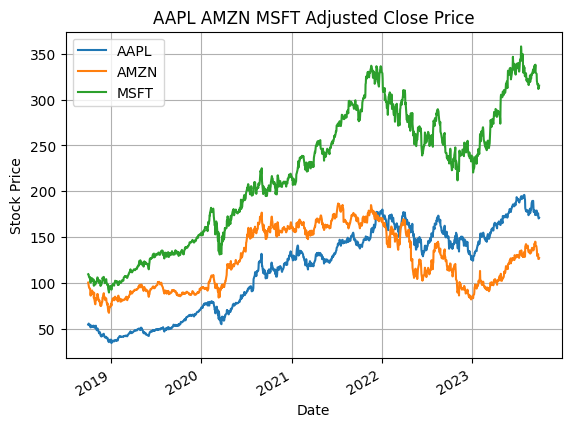

In [4]:
sorted_data = stock_data.sort_values(by="Date", ascending=False)
stock_data['Adj Close'].plot(title=f"AAPL AMZN MSFT Adjusted Close Price", grid=True)
plt.ylabel('Stock Price')
plt.show()

In [5]:
stock_data_adj = stock_data[['Adj Close']]
stock_data_arr = stock_data_adj.values
stock_data_arr

array([[ 54.3420372 , 100.21800232, 109.31070709],
       [ 54.82506943,  98.56549835, 108.87576294],
       [ 55.49220657,  97.63800049, 108.89466858],
       ...,
       [170.20574951, 125.98000336, 312.15643311],
       [170.46542358, 125.98000336, 313.00473022],
       [170.98474121, 127.12000275, 315.11044312]])

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data_arr)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQUENCE_LENGTH = 183  # Using last 6 months of data to predict the next day
x, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

train_size= int(0.8 * len(x))

X_train = x[:train_size]
y_train = y[:train_size]
X_test = x[train_size:]
y_test = y[train_size:]

X_train.shape

(860, 183, 3)

In [8]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],3)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(3)
])

model.compile(loss='mean_squared_error',
              optimizer='adam')

In [9]:
history = model.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=64)

Epoch 1/200
14/14 [==============================] - 5s 149ms/step - loss: 0.0973
Epoch 2/200
14/14 [==============================] - 2s 149ms/step - loss: 0.0272
Epoch 3/200
14/14 [==============================] - 2s 152ms/step - loss: 0.0192
Epoch 4/200
14/14 [==============================] - 2s 136ms/step - loss: 0.0153
Epoch 5/200
14/14 [==============================] - 2s 131ms/step - loss: 0.0109
Epoch 6/200
14/14 [==============================] - 2s 135ms/step - loss: 0.0100
Epoch 7/200
14/14 [==============================] - 2s 130ms/step - loss: 0.0097
Epoch 8/200
14/14 [==============================] - 2s 139ms/step - loss: 0.0089
Epoch 9/200
14/14 [==============================] - 2s 147ms/step - loss: 0.0087
Epoch 10/200
14/14 [==============================] - 2s 151ms/step - loss: 0.0082
Epoch 11/200
14/14 [==============================] - 2s 147ms/step - loss: 0.0084
Epoch 12/200
14/14 [==============================] - 2s 136ms/step - loss: 0.0075
Epoch 13/200


In [10]:
predicted_stock_price = model.predict(X_test)
actual_predictions = scaler.inverse_transform(predicted_stock_price)

7/7 [==============================] - 1s 28ms/step


In [15]:
rmse = np.sqrt(np.mean(np.square(actual_predictions - scaler.inverse_transform(y_test))))
rmse

9.62216110436033

(1043, 3)


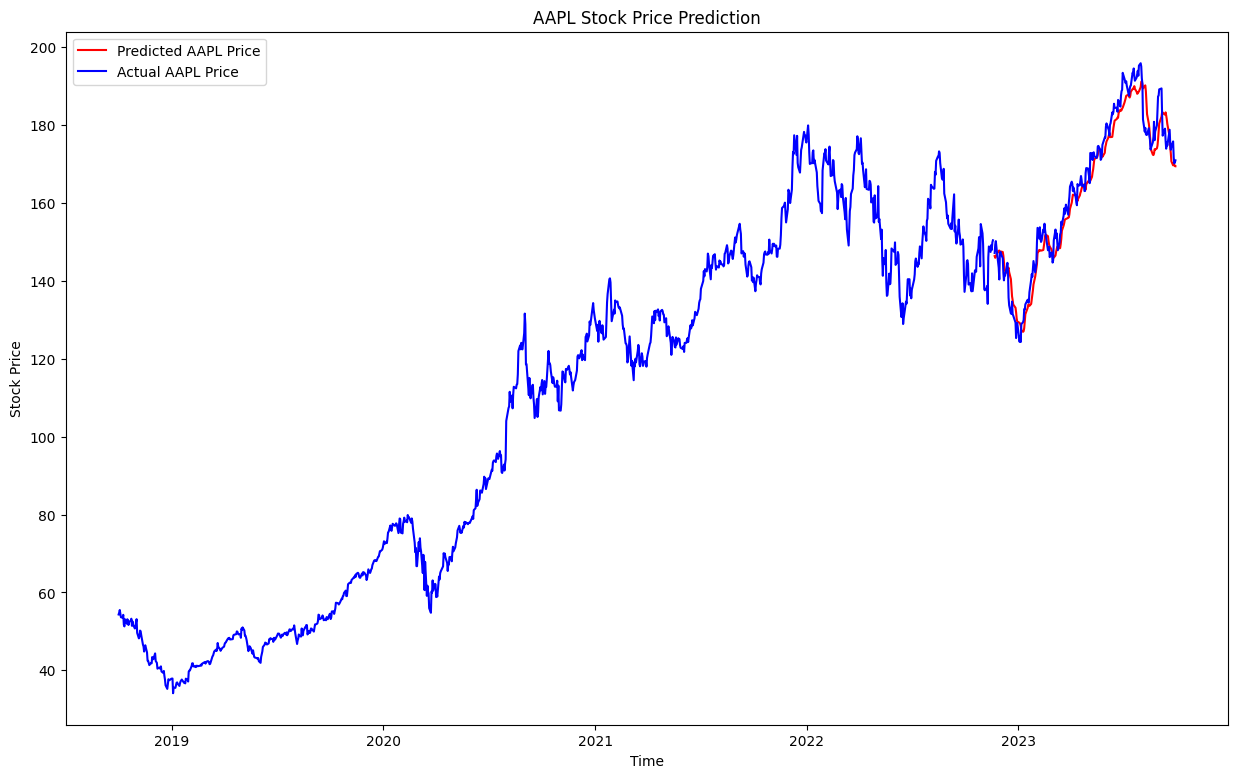

In [12]:
train = stock_data_adj[:train_size+SEQUENCE_LENGTH]
test = stock_data_adj[train_size+SEQUENCE_LENGTH:]

print(train.shape)

plt.figure(figsize=(15,9))
plt.plot(train['Adj Close']['AAPL'], color='blue')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions[:, 0], color='red', label='Predicted AAPL Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y_test)[:, 0], color='blue', label='Actual AAPL Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


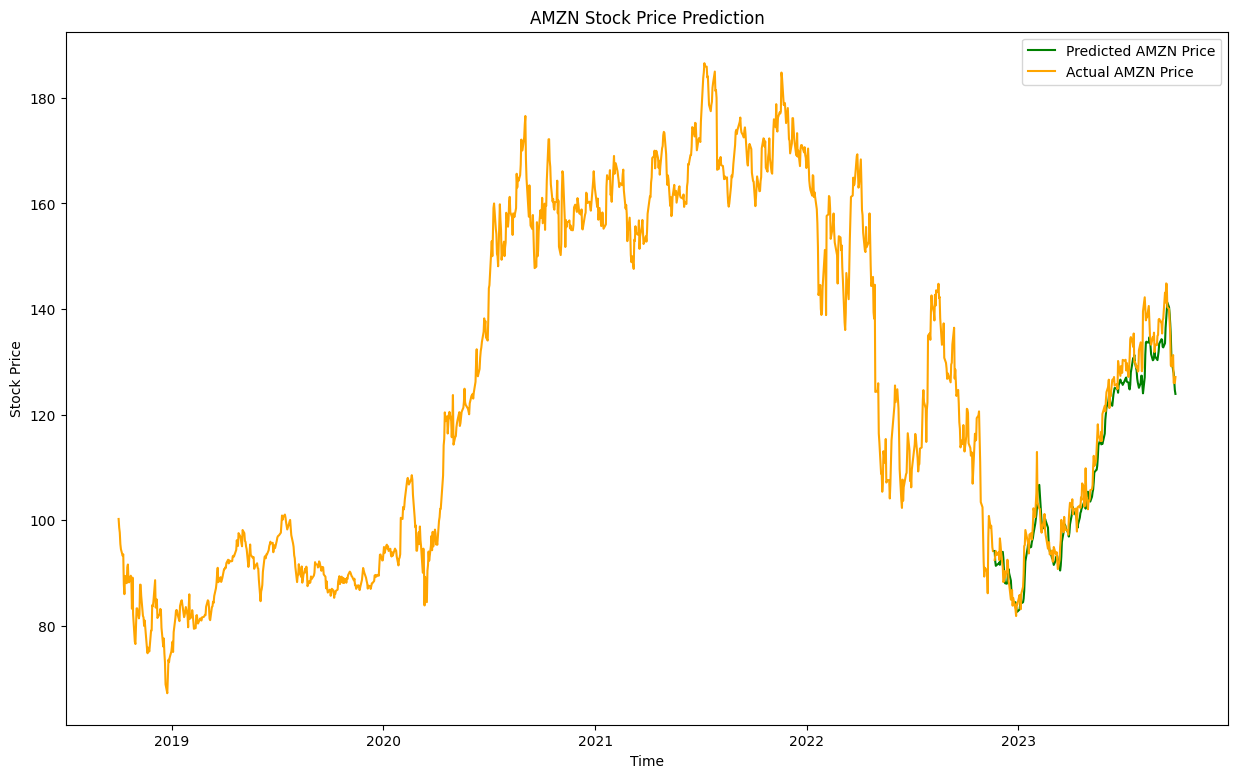

In [13]:
plt.figure(figsize=(15,9))
plt.plot(train['Adj Close']['AMZN'], color='orange')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions[:, 1], color='green', label='Predicted AMZN Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y_test)[:, 1], color='orange', label='Actual AMZN Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

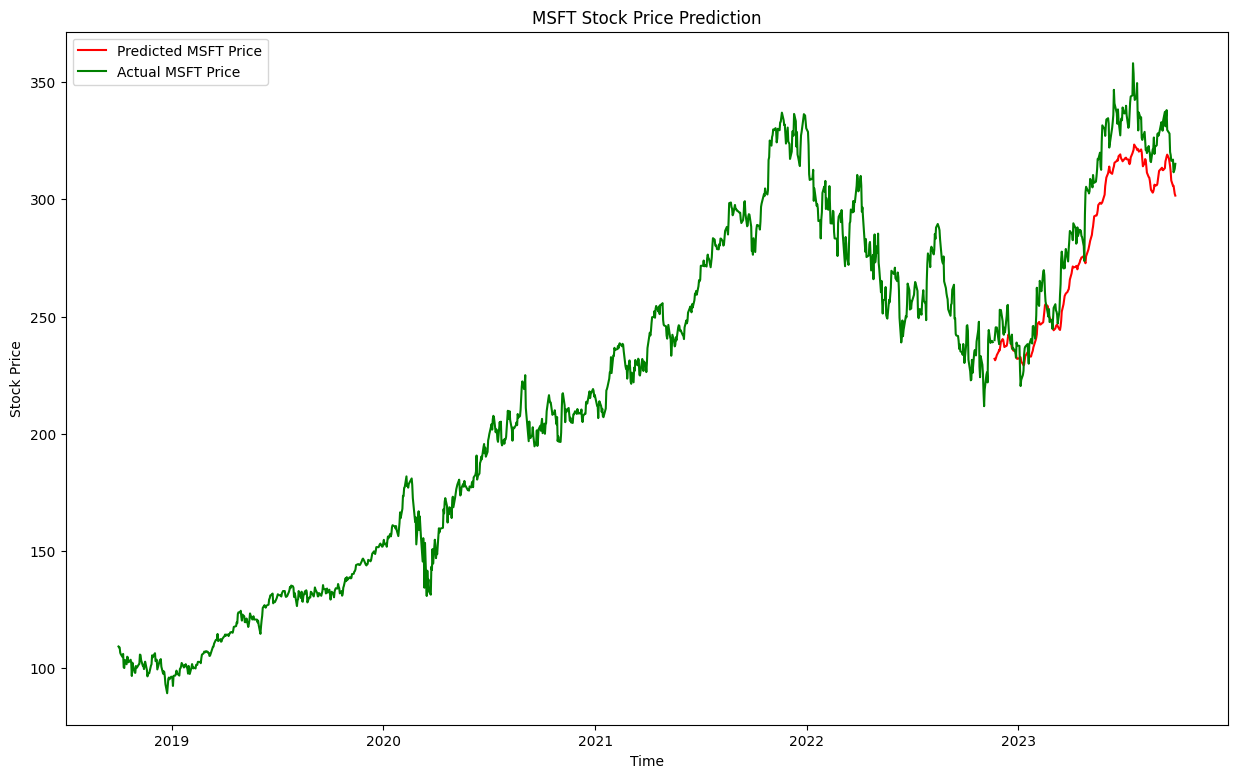

In [14]:
plt.figure(figsize=(15,9))
plt.plot(train['Adj Close']['MSFT'], color='green')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions[:, 2], color='red', label='Predicted MSFT Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y_test)[:, 2], color='green', label='Actual MSFT Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()